# Amex - Analyze this 2017

In [1]:
# Initial imports
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import random
from sklearn.decomposition import PCA

import datetime
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import boxcox

random.seed(3)

# Imports for better visualization
from matplotlib import rcParams
#colorbrewer2 Dark2 qualitative color table
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

rcParams['figure.figsize'] = (8, 3)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'
rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = '#eeeeee'

## Input data 

In [2]:
# Importing the data 
train=pd.read_csv("Modified_Training_Dataset.csv")
test=pd.read_csv("Modified_Leaderboard_Dataset.csv")

In [3]:
train.shape

(40000, 52)

In [4]:
train.head()

,cm_key,mvar1,mvar2,mvar3,mvar4,mvar5,mvar6,mvar7,mvar8,mvar9,...,mvar42,mvar43,mvar44,mvar45,mvar46,mvar47,mvar48,mvar49,mvar50,mvar51
0,1,Charge,0,106920,4,18,970,0.7969,0.1831,337236,...,0,0,0,0,0,0,1,0,0,0
1,2,Charge,2,0,4,19,1030,0.0678,0.0000,2918974,...,0,0,0,0,1,0,0,0,0,0
2,3,Charge,2,399168,4,35,327,0.7551,0.2986,498656,...,0,0,0,0,0,0,1,0,0,0
3,4,Charge,0,267300,4,274,1258,0.7969,0.5297,2480074,...,0,1,0,0,0,0,1,0,0,1
4,5,Charge,0,213840,6,1,0,2.3238,0.0000,2918974,...,0,0,0,0,1,0,0,1,0,0


In [5]:
data=pd.concat([train, test])

## Preprocessing & Feature engineering

In [6]:
# Missing values in mvar3 were imputed with median after grouping down the data according to Family size.
data["mvar3"][data.mvar3 == 0] = np.nan
data["mvar3"] = data.groupby("mvar2").mvar3.transform(lambda x: x.fillna(x.median()))

In [7]:
# Dataset contains many variables which are very skewed so those variables were normalized using box-cox transformations
# Upper cap is set to 99 percentile of its value
# Boosting model tend to perform poorly when values of single type occur many times in a single columns
# so to compensate that random noise was also added to continuous features.

skewed = ["mvar3", "mvar9", 
          "mvar16", "mvar17", "mvar18", "mvar19",
          "mvar20", "mvar21", "mvar22", "mvar23",
          "mvar24", "mvar25", "mvar26", "mvar27",
          "mvar28", "mvar29", "mvar30", "mvar31",
          "mvar32", "mvar33", "mvar34", "mvar35",
          "mvar36", "mvar37", "mvar38", "mvar39"]

def normalizing(X):
    data[X][data[X] < 0]=0
    data[X][data[X] > data[X].quantile(0.99)] = data[X].quantile(0.99)
    data[X] = data[X].apply(lambda x: x+np.random.rand())
    
    data[X] = data[X].apply(lambda x: x+1)
    data[X], _ = boxcox(data[X])

for i in skewed:
    normalizing(i)

In [8]:
# Feature engineering

data['electronics'] =  data.mvar16 + data.mvar17 + data.mvar18 + data.mvar19 
data['travel'] =  data.mvar21 + data.mvar22 + data.mvar23 + data.mvar20 
data['household'] =  data.mvar25 + data.mvar26 + data.mvar27 + data.mvar24
data['car'] =  data.mvar29 + data.mvar30 + data.mvar31 + data.mvar28
data['retail'] =  data.mvar33 + data.mvar34 + data.mvar35 + data.mvar32
data['total'] =  data.mvar36 + data.mvar37 + data.mvar38 + data.mvar39 

data['per_supp'] = data.mvar43/ data.mvar40
data['per_elite'] = data.mvar44/ data.mvar41
data['per_credit'] = data.mvar45/ data.mvar42


In [9]:
# For family size >= 4, supp card is preferred
data['mvar2_flag'] = 0
data['mvar2_flag'][data.mvar2 >= 4] = 1

# If Number of club memberships >= 2--> High chances of getting card
data['mvar14_flag'] = 0
data['mvar14_flag'][data.mvar14 >= 2] = 1

In [10]:
data['total_internal_score'] = data.mvar7 + data.mvar8 + data.mvar11/7
data['total_club_memberships'] =  data.mvar14 + data.mvar15
data['payement_per_card'] =  (data.mvar13*1.0)/data.mvar4
data['fees_per_club'] =  (data.mvar6*1.0)/data.mvar14
data['Income_per_member'] = (data.mvar9*1.0)/data.mvar2
data['spending_per_member'] =  (data.mvar3*1.0)/data.mvar2

In [11]:

# data['travel_spend_per_air_membership'] = data['travel']/data['mvar15']
# data["PercentageAccepted"] = (data["mvar45"] + data["mvar44"] + data["mvar43"])/(data["mvar42"] + data["mvar41"] + data["mvar40"])
# data["TotalAccepted"] = (data["mvar45"] + data["mvar44"] + data["mvar43"])

In [12]:
# dimentionality reduction on Spend features
# pca2 = PCA(1)
# Electronics_features = ['mvar16','mvar17','mvar18','mvar19']
# data['Electronics_pca']=pca2.fit_transform(data[Electronics_features])

# # data.drop(Electronics_features,axis=1,inplace=True)

# pca2 = PCA(1)
# Travel_features = ['mvar20','mvar21','mvar22','mvar23']
# data['Travel_pca']=pca2.fit_transform(data[Travel_features])

# pca2 = PCA(1)
# Household_features = ['mvar24','mvar25','mvar26','mvar27']
# data['Household_pca']=pca2.fit_transform(data[Household_features])


# pca2 = PCA(1)
# Car_features = ['mvar28','mvar29','mvar30','mvar31']
# data['Car_pca']=pca2.fit_transform(data[Car_features])

# pca2 = PCA(1)
# Retail_features = ['mvar32','mvar33','mvar34','mvar35']
# data['Retail_pca']=pca2.fit_transform(data[Retail_features])

# pca2 = PCA(1)
# Total_features = ['mvar36','mvar37','mvar38','mvar39']
# data['Total_pca']=pca2.fit_transform(data[Total_features])

In [13]:
# from sklearn.preprocessing import LabelEncoder,OneHotEncoder
# l=LabelEncoder() 
# data.mvar12 = l.fit_transform(data.mvar12)

In [14]:
# categorical = ["mvar12"]

# for i in categorical:
#     dummy = pd.get_dummies(data[i], prefix=i)
#     data = pd.concat([data, dummy], axis=1)
# #     data.drop([i], axis=1, inplace=True)

## Model 

In [15]:
def preparing_data(train,test, flag):
    
    if(flag == 'Credit'):
        data["Y"] = abs(data.mvar51)
        train["Y"] = abs(train.mvar51)

    if(flag == 'Elite'):
        data["Y"] = abs(data.mvar50)
        train["Y"] = abs(train.mvar50)

    if(flag == 'Supp'):
        data["Y"] = abs(data.mvar49)
        train["Y"] = abs(train.mvar49)
        
    if(flag == 'None'):
        data["Y"] = abs(data.mvar49 + data.mvar50 + data.mvar51-1)
        train["Y"] = abs(train.mvar49 + train.mvar50 + train.mvar51-1)
        
    # Since Family size and Industry code in which the customer has spent the most in past contained many labels 
    # so dummy encoding would create too many variables (curse of dimensionality). 
    # Therefore each of these were replaced with two new features

    categorical = ["mvar12", "mvar2"]

    def replacing_categorical(X):
        x=train.groupby(X)["Y"].mean()
        y=train.groupby(X)["Y"].std()
        data[X+str("_mean")]= data[X].apply(lambda X1: x[X1])
        data[X+str("_std")] = data[X].apply(lambda X2: y[X2])
    #     del data[X]

    for i in categorical:
        replacing_categorical(i)
   
    train_new = data.iloc[0:train.shape[0]]
    test_new = data.iloc[train.shape[0]:data.shape[0]]

    def prepare_data(df, is_train):
        # Dropping cm_key
        df = df.drop(["cm_key"], axis=1)
        # Dropping mvar1 due to uniformity
        df  = df.drop(["mvar1"], axis=1)
        if is_train:
            return df.drop([ 'mvar12',"Y", "mvar46", "mvar47", "mvar48", "mvar49", "mvar50", "mvar51"], axis=1), df['Y']
        return     df.drop([ 'mvar12',"Y", "mvar46", "mvar47", "mvar48", "mvar49", "mvar50", "mvar51"], axis=1)


    train_features, train_target =prepare_data(train_new, 1)
    test_features = prepare_data(test_new,0)
    
    return train_features, train_target, test_features

In [16]:
import xgboost
from sklearn.cross_validation import train_test_split

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score

In [17]:
def model(train,test,flag):
    train_features, train_target, test_features = preparing_data(train,test, flag)
    Xtrain, Xtest, ytrain, ytest = train_test_split( train_features, train_target,
                                                    stratify=train_target, test_size=.3, random_state=100)
    
    xgb = XGBClassifier(n_estimators= 1000, seed=100)
    xgb.fit( train_features, train_target )

    print ("Training :"+str(accuracy_score( ytrain, xgb.predict(Xtrain))))
    print ("Test :"+str(accuracy_score( ytest, xgb.predict(Xtest))))
    print ("ROC_AUC :"+str(roc_auc_score( ytest, xgb.predict(Xtest))))
    print ("precision_score :"+str(precision_score( ytest, xgb.predict(Xtest))))
    print ("recall_score :"+str(recall_score( ytest, xgb.predict(Xtest))))
    print ("confusion_matrix :"+ str(confusion_matrix(ytest, xgb.predict(Xtest))))

    def myscorer(cm):
        False1 = cm[0][1]
        False2 = cm[1][0]
        return (3*False1) + (False2), (False1+False2)

    print ("myscorer :"+ str(myscorer(confusion_matrix(ytest, xgb.predict(Xtest)))))
           
    ax = xgboost.plot_importance(xgb)
    fig = ax.figure
    fig.set_size_inches(15, 15)

Training :0.926178571429
Test :0.928666666667
ROC_AUC :0.587825355036
precision_score :0.978494623656
recall_score :0.176015473888
confusion_matrix :[[10962     4]
 [  852   182]]
myscorer :(864, 856)


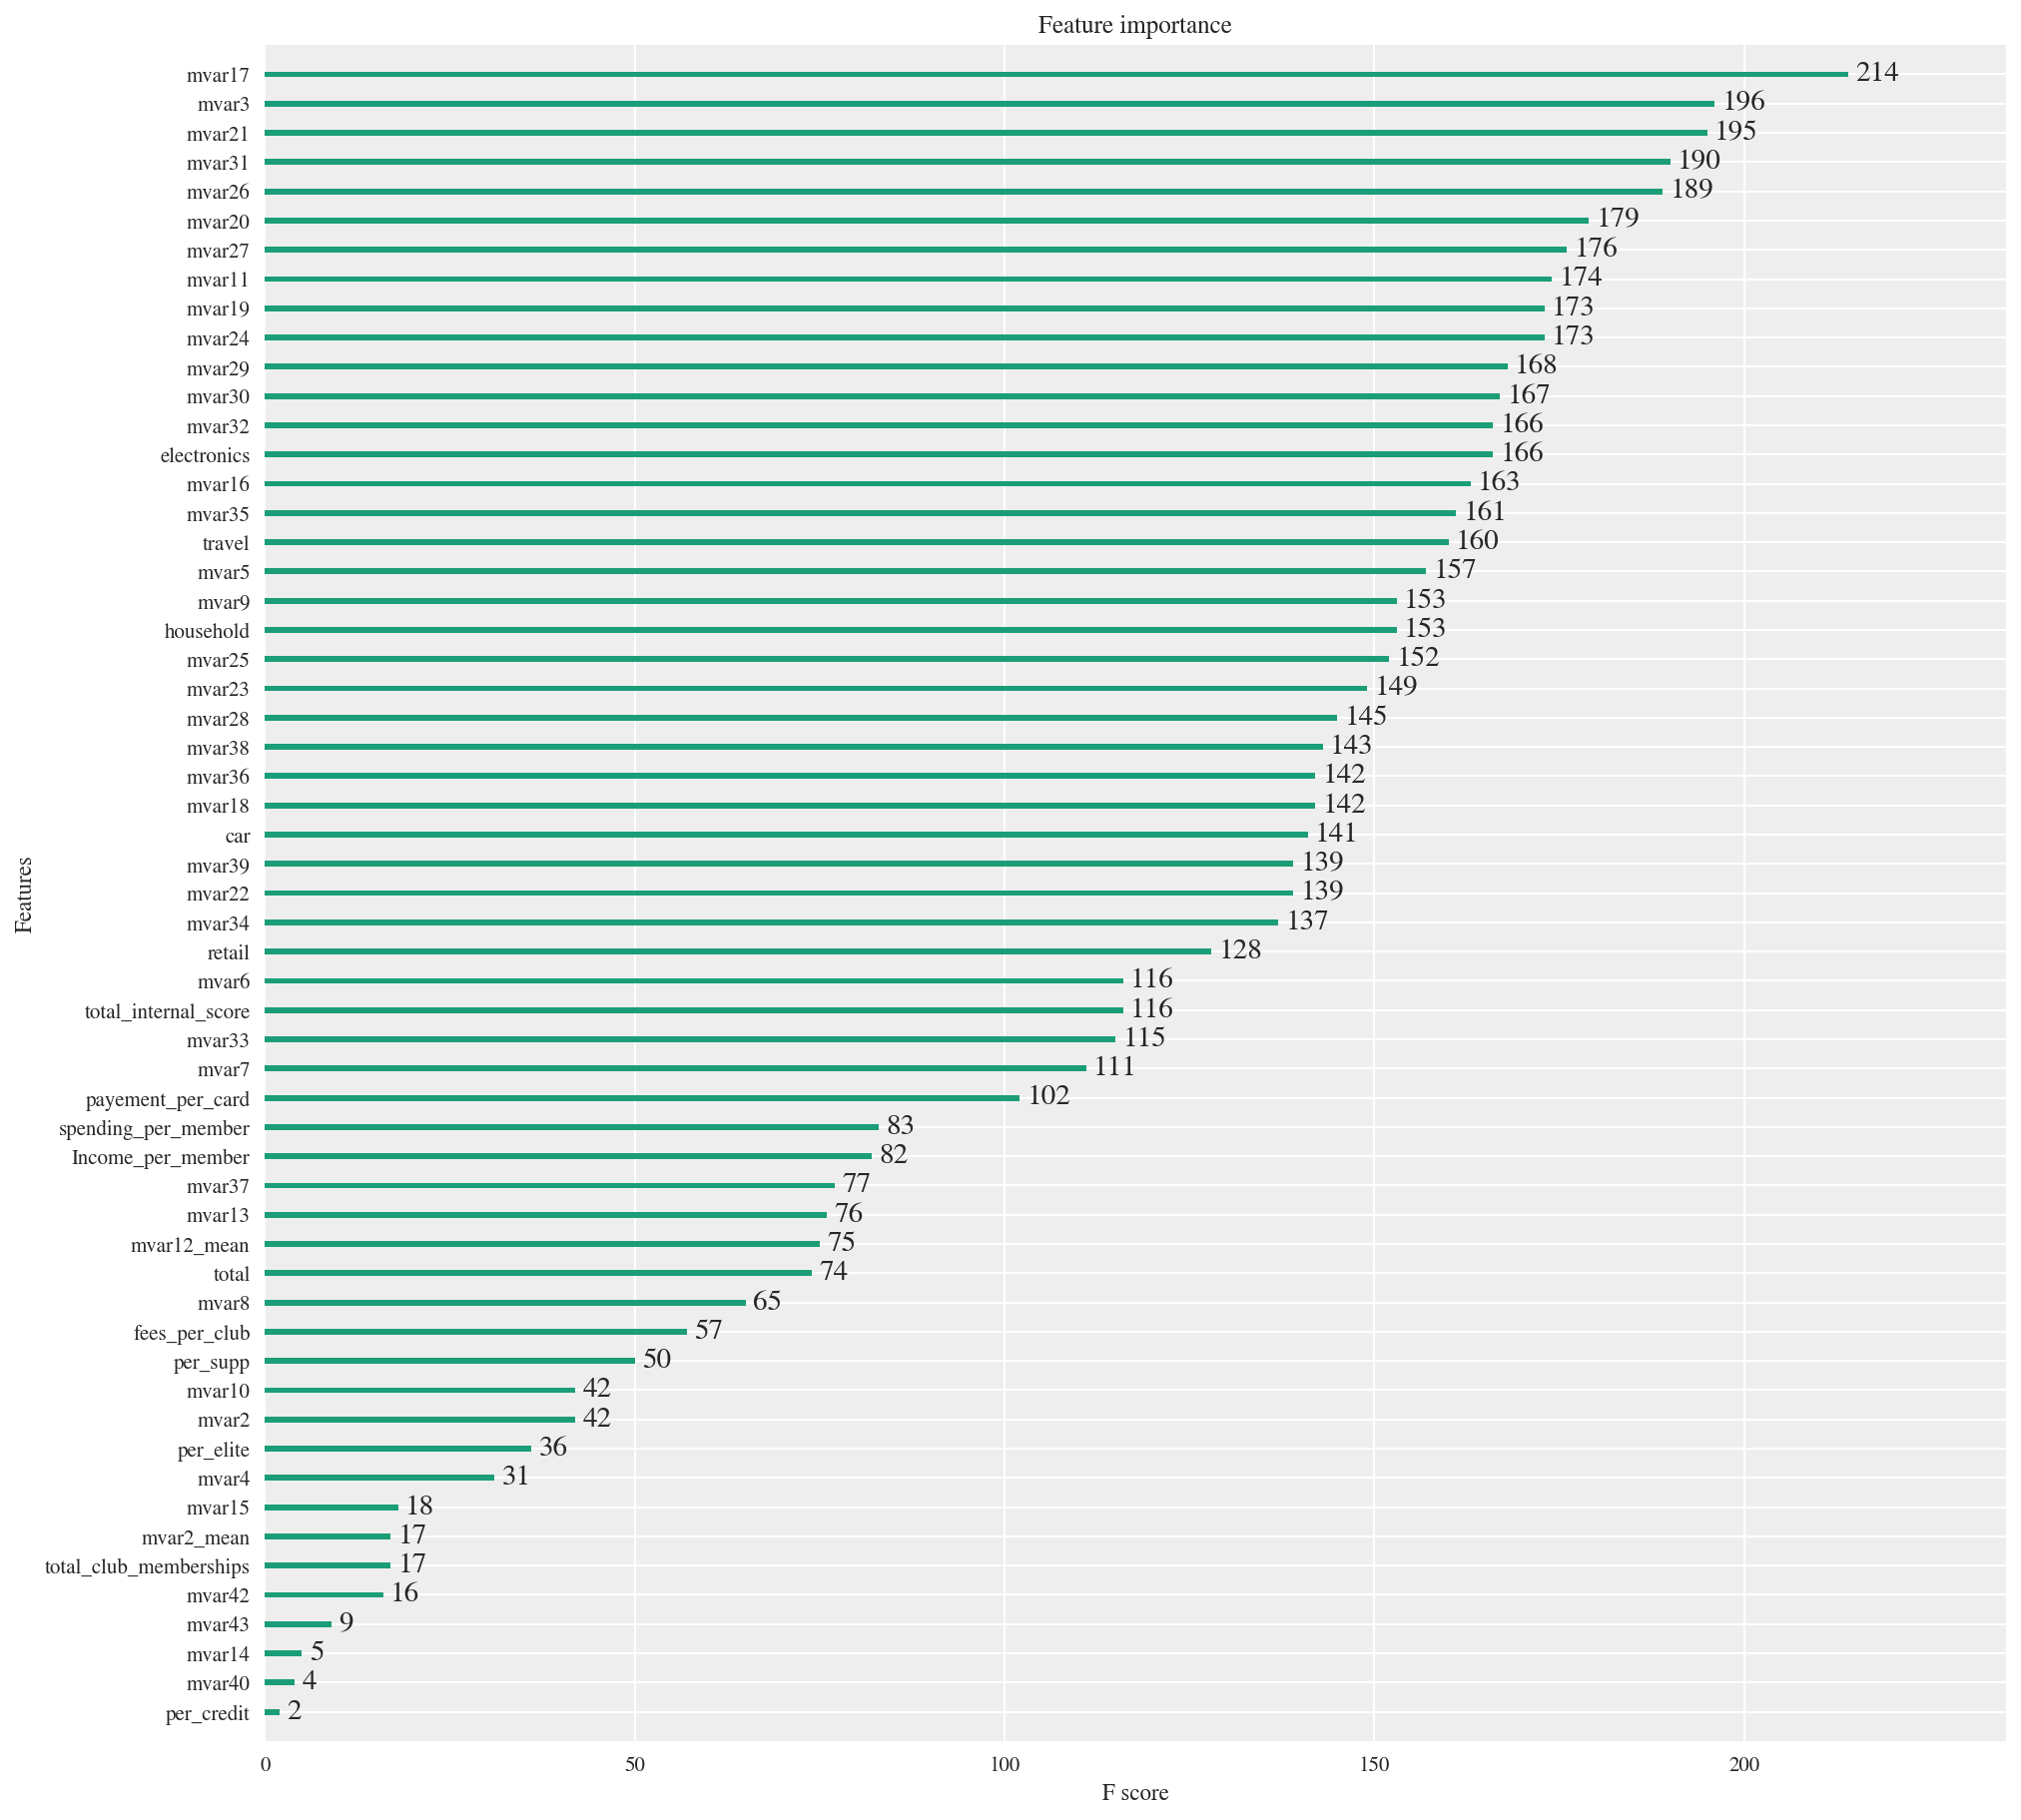

In [18]:
model(train,test,'Supp')

In [19]:
# Training on Supp data
train_features, train_target, test_features = preparing_data(train,test, "Supp")
xgb = XGBClassifier(n_estimators= 1000, seed=100)
xgb.fit(train_features, train_target)
submission = pd.concat([test["cm_key"], pd.DataFrame(xgb.predict_proba(test_features), columns=["Supp_NO","Supp_Yes"])], axis=1)
submission.to_csv("Supp.csv", index=False)

In [20]:
# Training on Elite data
train_features, train_target, test_features = preparing_data(train,test, "Elite")
xgb = XGBClassifier(n_estimators= 1000, seed=100)
xgb.fit(train_features, train_target)
submission = pd.concat([test["cm_key"], pd.DataFrame(xgb.predict_proba(test_features), columns=["Elite_NO","Elite_Yes"])], axis=1)
submission.to_csv("Elite.csv", index=False)

In [21]:
# Training on credit data
train_features, train_target, test_features = preparing_data(train,test, "Credit")
xgb = XGBClassifier(n_estimators= 1000, seed=100)
xgb.fit(train_features, train_target)
submission = pd.concat([test["cm_key"], pd.DataFrame(xgb.predict_proba(test_features), columns=["Credit_NO","Credit_Yes"])], axis=1)
submission.to_csv("Credit.csv", index=False)

In [22]:
# Training on None  class data
train_features, train_target, test_features = preparing_data(train,test, "None")
xgb = XGBClassifier(n_estimators= 1000, seed=100)
xgb.fit(train_features, train_target)
submission = pd.concat([test["cm_key"], pd.DataFrame(xgb.predict_proba(test_features), columns=["None_NO","None_Yes"])], axis=1)
submission.to_csv("NOne.csv", index=False)

## Strategies to decide final submission

In [23]:
Supp = pd.read_csv("Supp.csv")
Credit = pd.read_csv("Credit.csv")
Elite = pd.read_csv("Elite.csv")
NOne = pd.read_csv("NOne.csv")

In [24]:
Supp.head(2)

,cm_key,Supp_NO,Supp_Yes
0,50001,0.906858,0.093142
1,50002,0.968705,0.031295


In [25]:
data = pd.merge(Supp, Credit, how="inner")
data = pd.merge(data, Elite, how="inner")
data = pd.merge(data, NOne, how="inner")

In [26]:
data.shape

(10000, 9)

In [27]:
data.head(2)

,cm_key,Supp_NO,Supp_Yes,Credit_NO,Credit_Yes,Elite_NO,Elite_Yes,None_NO,None_Yes
0,50001,0.906858,0.093142,0.943825,0.056175,0.887430,0.112570,0.340754,0.659246
1,50002,0.968705,0.031295,0.997677,0.002323,0.983464,0.016536,0.088599,0.911401


## According to Max

In [28]:
data["Max"] = data.apply(lambda x: max(x["Supp_Yes"], x["Elite_Yes"], x["Credit_Yes"]), axis=1)
data["predict"] = "Supp"
data["predict"][data.Max == data.Elite_Yes] = "Elite"
data["predict"][data.Max == data.Credit_Yes] = "Credit"

In [29]:
data['Rank_Max'] = data["Max"].rank(ascending=0)
data = data.sort(["Rank_Max"], ascending = 1)

In [30]:
data.head(2)

,cm_key,Supp_NO,Supp_Yes,Credit_NO,Credit_Yes,Elite_NO,Elite_Yes,None_NO,None_Yes,Max,predict,Rank_Max
8317,58318,0.093764,0.906236,0.992138,0.007862,0.986590,0.013410,0.665688,0.334312,0.906236,Supp,1.0
4528,54529,0.953334,0.046666,0.997538,0.002462,0.101005,0.898995,0.473090,0.526910,0.898995,Elite,2.0


## According to None

In [31]:
data['RankNone'] = data["None_Yes"].rank(ascending=1)
data = data.sort(["RankNone"], ascending = 1)

In [32]:
data.head(2)

,cm_key,Supp_NO,Supp_Yes,Credit_NO,Credit_Yes,Elite_NO,Elite_Yes,None_NO,None_Yes,Max,predict,Rank_Max,RankNone
5802,55803,0.386536,0.613464,0.980758,0.019242,0.941721,0.058279,0.818919,0.181081,0.613464,Supp,72.0,1.0
6403,56404,0.968501,0.031499,0.972415,0.027585,0.391493,0.608507,0.791173,0.208827,0.608507,Elite,79.0,2.0


## According to Supp_No + Credit_No + Elite_No + None_Yes

In [33]:
data["No"] = data.Supp_NO + data.Credit_NO + data.Elite_NO + data.None_Yes

data['Rank_NO'] = data["No"].rank(ascending=1)
data = data.sort(["Rank_NO"], ascending = 1)

In [34]:
del data["Supp_NO"]
del data["Credit_NO"]
del data["Elite_NO"]
del data["None_NO"]

In [35]:
data.head(2)

,cm_key,Supp_Yes,Credit_Yes,Elite_Yes,None_Yes,Max,predict,Rank_Max,RankNone,No,Rank_NO
4,50005,0.029778,0.206154,0.880319,0.322535,0.880319,Elite,3.0,33.0,2.206285,1.0
2911,52912,0.021367,0.369724,0.605277,0.329549,0.605277,Elite,81.0,37.0,2.333181,2.0


## According to Max -  None

In [36]:
data["Max-None"] = data["Max"] - data["None_Yes"]

data['Rank_Max-None'] = data["Max-None"].rank(ascending=0)
data = data.sort(["Rank_Max-None"], ascending = 1)

In [37]:
data.head(2)

,cm_key,Supp_Yes,Credit_Yes,Elite_Yes,None_Yes,Max,predict,Rank_Max,RankNone,No,Rank_NO,Max-None,Rank_Max-None
8930,58931,0.029410,0.025412,0.83391,0.245424,0.833910,Elite,7.0,7.0,2.356693,3.0,0.588486,1.0
8317,58318,0.906236,0.007862,0.01341,0.334312,0.906236,Supp,1.0,39.0,2.406803,10.0,0.571925,2.0


## Ensembling

In [38]:
data["Rank_Combine"] = data["Rank_Max-None"] + data["Rank_NO"]

In [39]:
data = data.sort(["Rank_Combine"], ascending = 1)
submission = data[["cm_key", "predict"]][0:1000]

In [40]:
data.head(2)

,cm_key,Supp_Yes,Credit_Yes,Elite_Yes,None_Yes,Max,predict,Rank_Max,RankNone,No,Rank_NO,Max-None,Rank_Max-None,Rank_Combine
8930,58931,0.029410,0.025412,0.833910,0.245424,0.833910,Elite,7.0,7.0,2.356693,3.0,0.588486,1.0,4.0
4,50005,0.029778,0.206154,0.880319,0.322535,0.880319,Elite,3.0,33.0,2.206285,1.0,0.557783,3.0,4.0


In [41]:
submission.head(2)

,cm_key,predict
8930,58931,Elite
4,50005,Elite


In [42]:
submission["predict"].value_counts()

Elite     367
Credit    351
Supp      282
Name: predict, dtype: int64

In [43]:
now = datetime.datetime.now()
submission.to_csv("Models_" + str(now.day) + "_" + str(now.hour) +"_" + str(now.minute) + ".csv", index=False,header=None)